In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import sys

from tqdm import tqdm_notebook

from nltk import ngrams

In [3]:
import itertools
from itertools import tee

import editdistance as ed

In [4]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [5]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [6]:
# Check randint
def generate_repeat(repeat_a, repeat_b):
    transition_pos = np.random.randint(0, len(repeat_a) + 1)
    return repeat_a[0:transition_pos] + repeat_b[transition_pos:]

In [7]:
class RepeatsDescr:
    def __init__(self, repeats):
        self.n = len(repeats)
        self.repeats = repeats
        self.repeat_to_n = dict(zip(self.repeats, np.arange(len(repeats))))
        self.n_to_repeat = dict(zip(np.arange(len(repeats)), self.repeats))
        self.mat = self._create_complementory_matrix()

    def add_repeat(self, repeat):
        self.repeats.append(repeat)
        self.repeat_to_n[repeat] = self.n
        self.n_to_repeat[self.n] = repeat
        self.n += 1
        self._update_complementory_matrix()
        
    def _create_complementory_matrix(self):
        mat = np.zeros((self.n, self.n))

        for r1, r2 in itertools.product(self.repeats, self.repeats):
            mat[self.repeat_to_n[r1]][self.repeat_to_n[r2]] = 1 - (ed.eval(r1,r2) / max(len(r1), len(r2)))
        return mat
    
    def _update_complementory_matrix(self):
        self.mat = np.pad(self.mat, ((0,1), (0,1)), mode = 'constant')
        
        for r in self.repeats:
            val = 1 - (ed.eval(r,repeats[-1]) / max(len(r), len(repeats[-1])))
            self.mat[self.repeat_to_n[r], self.repeat_to_n[repeats[-1]]] = val
            self.mat[self.repeat_to_n[repeats[-1]], self.repeat_to_n[r]] = val

In [8]:
repeats = ['aaaaaaaaaa',
           'aaaaaaaaab',
           'aaaaaaaabb']

repeats_descr = RepeatsDescr(repeats)

In [9]:
repeats_descr.add_repeat("aaaaaaabbb")

In [792]:
class Population:
    def __init__(self,
                 initial_population, 
                 primers_counts,
                 max_len = 10):
        self.max_len = max_len
        self.max_size = (sum(primers_counts.values()) + len(initial_population))
        
        self.p = np.ones((self.max_size, self.max_len)).astype(int) * -1
        
        pos = 0
        for arr in initial_population:
            self.p[pos, (max_len - len(arr)) // 2: (max_len - len(arr)) // 2 + len(arr)] = arr
            pos += 1
        for k, v in primers_counts.items():
            self.p[pos: pos + v, max_len // 2 ] = k
            pos += v
        
        self.glue_mask = self.p[:, ::2].flatten() != -1
        
        if V == 'DEBUG' or V == 'DEBUG_1':
            print(self.p, "\n")   
            
    
    def get_rep_pos_by_ind(self, ind):
        return (ind * 2 // self.p.shape[1], ind * 2 % self.p.shape[1])
    
    
    def get_rep_by_ind(self, ind):
        return self.p[:,::2].flatten()[ind]

    def _recalc_glue_mask(self):
        self.glue_mask = self.p[:, ::2].flatten() != -1

In [793]:
from copy import deepcopy

In [896]:
class PCR:
    def __init__(self, population, repeats_descr):
        self.fp = population
        self.bp = deepcopy(population)
#         self.ni = population.p.shape[0]
#         self.nj = population.p.shape[1]
        
        self.comp_mat = np.zeros((self.fp.glue_mask.shape[0], self.fp.glue_mask.shape[0]))
        
        for i in np.where(self.fp.glue_mask)[0]:
            for j in np.where(self.bp.glue_mask)[0]:
                self.comp_mat[i][j] = repeats_descr.mat[self.fp.get_rep_by_ind(i), self.fp.get_rep_by_ind(j)]
                
    def _annealing(self):
        self.anneal_all = (np.random.random(size = self.comp_mat.shape) < self.comp_mat).astype(int)
        self.anneal = np.zeros_like(self.comp_mat)
        #indexes = np.arange(self.anneal_all.shape[0])[self.anneal_all.sum(1) != 0]
        #np.random.shuffle(indexes)
        indexes = np.arange(self.anneal_all.shape[0])
        np.random.shuffle(indexes)
        
        for i in indexes:
            row = self.anneal_all[i]
            if row.sum() != 0:
                j = np.random.choice(np.arange(self.comp_mat.shape[0]), size = 1, p = row.astype(float) / row.sum())

                if np.random.random() < 0.5 * self.anneal_all[i, j]:
                    self.anneal[i, j] = 1
                    self.anneal[j, i] = 1

                self.anneal_all[i] = 0
                self.anneal_all[:, i] = 0
                self.anneal_all[j] = 0
                self.anneal_all[:, j] = 0
            
            
    def _amplify(self):
        
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            print(f, b, '; ', fi, fj, '; ', bi, bj)
            
            self.glue_f_to_b(fi, fj, bi, bj)
            self.glue_b_to_f(fi, fj, bi, bj)
            
            
    def glue_f_to_b(self, fi, fj, bi, bj):
        if self.fp.p[fi][fj + 1] == -1 and fj + 2 != self.fp.max_len:
            copy_part = self.bp.p[bi][bj:][self.bp.p[bi][bj:] != -1][: self.fp.max_len - fj]
            self.fp.p[fi][fj:fj + copy_part.shape[0]] = copy_part
    
    
    def glue_b_to_f(self, fi, fj, bi, bj):
        if bj > 0 and self.bp.p[bi][bj - 1] == -1:
            copy_part = self.fp.p[fi][:fj][self.fp.p[fi][:fj] != -1][fj - bj - 1:fj]
            self.bp.p[bi][bj - copy_part.shape[0]:bj] = copy_part
            
            
    def print_glue_points(self):
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            print(f, b, '; ', fi, fj, '; ', bi, bj)
            
    
    def cycle(self):
        self._annealing()
        self._amplify()
        self.fp, self.bp = self.bp, self.fp
    
    def to_pairs(self):
        all_pairs = {}
        for product in np.vstack((self.fp.p[:, 1::2],self.bp.p[:, 1::2])):
            for a,b in zip(product, product[1:]):
                if a!= -1 and b!= -1:
                    if (a,b) in all_pairs:
                        all_pairs[(a,b)] += 1
                    else:
                        all_pairs[(a,b)] = 1
        return all_pairs
    
    def to_graph(self, sp_num):
        gr = np.zeros((sp_num, sp_num))
        
        for p, n in self.to_pairs().items():
            gr[p[0]][p[1]] = n
        return gr
        

In [911]:
V = 'DEBUG_2'

In [912]:
p_list = [[0,0, 0,1, 0,2, 0,3, 0,4, 0], [0,1, 0,5, 0,6,0]]
primers_num = {0:100}
p = Population(p_list, primers_num, max_len=16)

In [913]:
p.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [914]:
p.p[-2:]

array([[-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [915]:
pcr = PCR(p, repeats_descr)

In [916]:
pcr.fp.p

array([[-1, -1,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [917]:
pcr.bp.p[:10]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [918]:
for i in range(40):
    pcr.cycle()

1 300 ;  0 2 ;  37 8
4 4 ;  0 8 ;  0 8
5 84 ;  0 10 ;  10 8
11 572 ;  1 6 ;  71 8
20 20 ;  2 8 ;  2 8
28 228 ;  3 8 ;  28 8
52 100 ;  6 8 ;  12 8
60 516 ;  7 8 ;  64 8
84 5 ;  10 8 ;  0 10
100 52 ;  12 8 ;  6 8
124 612 ;  15 8 ;  76 8
132 492 ;  16 8 ;  61 8
140 436 ;  17 8 ;  54 8
156 756 ;  19 8 ;  94 8
164 708 ;  20 8 ;  88 8
180 652 ;  22 8 ;  81 8
204 484 ;  25 8 ;  60 8
228 28 ;  28 8 ;  3 8
236 540 ;  29 8 ;  67 8
260 524 ;  32 8 ;  65 8
268 548 ;  33 8 ;  68 8
276 604 ;  34 8 ;  75 8
292 764 ;  36 8 ;  95 8
300 1 ;  37 8 ;  0 2
308 340 ;  38 8 ;  42 8
324 444 ;  40 8 ;  55 8
332 748 ;  41 8 ;  93 8
340 308 ;  42 8 ;  38 8
348 716 ;  43 8 ;  89 8
412 556 ;  51 8 ;  69 8
436 140 ;  54 8 ;  17 8
444 324 ;  55 8 ;  40 8
468 780 ;  58 8 ;  97 8
484 204 ;  60 8 ;  25 8
492 132 ;  61 8 ;  16 8
508 812 ;  63 8 ;  101 8
516 60 ;  64 8 ;  7 8
524 260 ;  65 8 ;  32 8
532 620 ;  66 8 ;  77 8
540 236 ;  67 8 ;  29 8
548 268 ;  68 8 ;  33 8
556 412 ;  69 8 ;  51 8
572 11 ;  71 8 ;  1 6
580 6

380 60 ;  47 8 ;  7 8
388 148 ;  48 8 ;  18 8
412 780 ;  51 8 ;  97 8
444 700 ;  55 8 ;  87 8
452 468 ;  56 8 ;  58 8
468 452 ;  58 8 ;  56 8
492 188 ;  61 8 ;  23 8
508 564 ;  63 8 ;  70 8
540 732 ;  67 8 ;  91 8
548 660 ;  68 8 ;  82 8
564 508 ;  70 8 ;  63 8
572 812 ;  71 8 ;  101 8
580 316 ;  72 8 ;  39 8
596 708 ;  74 8 ;  88 8
628 68 ;  78 8 ;  8 8
660 548 ;  82 8 ;  68 8
700 444 ;  87 8 ;  55 8
708 596 ;  88 8 ;  74 8
732 540 ;  91 8 ;  67 8
764 772 ;  95 8 ;  96 8
772 764 ;  96 8 ;  95 8
780 412 ;  97 8 ;  51 8
788 308 ;  98 8 ;  38 8
796 244 ;  99 8 ;  30 8
804 228 ;  100 8 ;  28 8
812 572 ;  101 8 ;  71 8
2 692 ;  0 4 ;  86 8
3 92 ;  0 6 ;  11 8
4 52 ;  0 8 ;  6 8
6 244 ;  0 12 ;  30 8
10 420 ;  1 4 ;  52 8
11 564 ;  1 6 ;  70 8
13 796 ;  1 10 ;  99 8
20 148 ;  2 8 ;  18 8
36 684 ;  4 8 ;  85 8
52 4 ;  6 8 ;  0 8
76 460 ;  9 8 ;  57 8
84 276 ;  10 8 ;  34 8
92 3 ;  11 8 ;  0 6
100 292 ;  12 8 ;  36 8
116 636 ;  14 8 ;  79 8
140 612 ;  17 8 ;  76 8
148 20 ;  18 8 ;  2 8
172 53

396 796 ;  49 8 ;  99 8
412 700 ;  51 8 ;  87 8
420 10 ;  52 8 ;  1 4
428 716 ;  53 8 ;  89 8
436 28 ;  54 8 ;  3 8
444 764 ;  55 8 ;  95 8
452 516 ;  56 8 ;  64 8
476 780 ;  59 8 ;  97 8
516 452 ;  64 8 ;  56 8
524 308 ;  65 8 ;  38 8
532 572 ;  66 8 ;  71 8
548 196 ;  68 8 ;  24 8
572 532 ;  71 8 ;  66 8
588 1 ;  73 8 ;  0 2
596 756 ;  74 8 ;  94 8
628 36 ;  78 8 ;  4 8
660 812 ;  82 8 ;  101 8
668 140 ;  83 8 ;  17 8
676 52 ;  84 8 ;  6 8
692 364 ;  86 8 ;  45 8
700 412 ;  87 8 ;  51 8
708 260 ;  88 8 ;  32 8
716 428 ;  89 8 ;  53 8
732 156 ;  91 8 ;  19 8
756 596 ;  94 8 ;  74 8
764 444 ;  95 8 ;  55 8
780 476 ;  97 8 ;  59 8
796 396 ;  99 8 ;  49 8
812 660 ;  101 8 ;  82 8
1 420 ;  0 2 ;  52 8
3 644 ;  0 6 ;  80 8
6 6 ;  0 12 ;  0 12
13 572 ;  1 10 ;  71 8
28 148 ;  3 8 ;  18 8
36 540 ;  4 8 ;  67 8
44 340 ;  5 8 ;  42 8
52 748 ;  6 8 ;  93 8
92 92 ;  11 8 ;  11 8
100 548 ;  12 8 ;  68 8
116 444 ;  14 8 ;  55 8
148 28 ;  18 8 ;  3 8
180 412 ;  22 8 ;  51 8
188 516 ;  23 8 ;  64 8


380 636 ;  47 8 ;  79 8
388 628 ;  48 8 ;  78 8
396 436 ;  49 8 ;  54 8
436 396 ;  54 8 ;  49 8
452 748 ;  56 8 ;  93 8
468 356 ;  58 8 ;  44 8
484 100 ;  60 8 ;  12 8
516 68 ;  64 8 ;  8 8
540 260 ;  67 8 ;  32 8
572 140 ;  71 8 ;  17 8
596 684 ;  74 8 ;  85 8
604 6 ;  75 8 ;  0 12
620 11 ;  77 8 ;  1 6
628 388 ;  78 8 ;  48 8
636 380 ;  79 8 ;  47 8
644 732 ;  80 8 ;  91 8
660 316 ;  82 8 ;  39 8
684 596 ;  85 8 ;  74 8
692 364 ;  86 8 ;  45 8
732 644 ;  91 8 ;  80 8
748 452 ;  93 8 ;  56 8
780 268 ;  97 8 ;  33 8
796 180 ;  99 8 ;  22 8
1 508 ;  0 2 ;  63 8
2 196 ;  0 4 ;  24 8
3 380 ;  0 6 ;  47 8
4 284 ;  0 8 ;  35 8
5 292 ;  0 10 ;  36 8
10 388 ;  1 4 ;  48 8
12 660 ;  1 8 ;  82 8
28 28 ;  3 8 ;  3 8
44 164 ;  5 8 ;  20 8
60 428 ;  7 8 ;  53 8
76 372 ;  9 8 ;  46 8
100 604 ;  12 8 ;  75 8
116 300 ;  14 8 ;  37 8
140 156 ;  17 8 ;  19 8
156 140 ;  19 8 ;  17 8
164 44 ;  20 8 ;  5 8
180 468 ;  22 8 ;  58 8
196 2 ;  24 8 ;  0 4
228 228 ;  28 8 ;  28 8
236 676 ;  29 8 ;  84 8
244 244

11 740 ;  1 6 ;  92 8
13 300 ;  1 10 ;  37 8
28 700 ;  3 8 ;  87 8
36 660 ;  4 8 ;  82 8
76 372 ;  9 8 ;  46 8
100 516 ;  12 8 ;  64 8
108 332 ;  13 8 ;  41 8
116 140 ;  14 8 ;  17 8
140 116 ;  17 8 ;  14 8
148 756 ;  18 8 ;  94 8
164 684 ;  20 8 ;  85 8
172 500 ;  21 8 ;  62 8
212 284 ;  26 8 ;  35 8
220 772 ;  27 8 ;  96 8
236 540 ;  29 8 ;  67 8
252 564 ;  31 8 ;  70 8
260 340 ;  32 8 ;  42 8
284 212 ;  35 8 ;  26 8
300 13 ;  37 8 ;  1 10
332 108 ;  41 8 ;  13 8
340 260 ;  42 8 ;  32 8
348 348 ;  43 8 ;  43 8
372 76 ;  46 8 ;  9 8
404 620 ;  50 8 ;  77 8
428 460 ;  53 8 ;  57 8
444 652 ;  55 8 ;  81 8
460 428 ;  57 8 ;  53 8
476 676 ;  59 8 ;  84 8
500 172 ;  62 8 ;  21 8
516 100 ;  64 8 ;  12 8
540 236 ;  67 8 ;  29 8
564 252 ;  70 8 ;  31 8
604 604 ;  75 8 ;  75 8
620 404 ;  77 8 ;  50 8
644 732 ;  80 8 ;  91 8
652 444 ;  81 8 ;  55 8
660 36 ;  82 8 ;  4 8
676 476 ;  84 8 ;  59 8
684 164 ;  85 8 ;  20 8
700 28 ;  87 8 ;  3 8
716 812 ;  89 8 ;  101 8
732 644 ;  91 8 ;  80 8
740 11 

ValueError: could not broadcast input array from shape (5) into shape (0)

In [905]:
pcr.fp.p[:3]

array([[ 0,  3,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0,  6,  0, -1],
       [-1,  1,  0,  2,  0,  1,  0,  5,  0,  6,  0,  0,  0,  1,  0,  2],
       [-1, -1, -1, -1, -1, -1, -1,  3,  0,  2,  0,  3,  0,  4,  0, -1]])

In [906]:
pcr.bp.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0,  1,  0,  5],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0,  1,  0,  2,  0,  3],
       [-1, -1, -1, -1, -1, -1, -1,  1,  0,  4,  0, -1, -1, -1, -1, -1]])

In [879]:
pcr.glue_f_to_b(2,8,0,2)

ValueError: could not broadcast input array from shape (11) into shape (8)

In [907]:
pcr.bp.p[0][2:][pcr.bp.p[0][2:] != -1]#[: 16 - 0]

array([0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 1, 0, 5])

In [908]:
pcr.to_graph(7)

array([[ 3., 66.,  3.,  3.,  3.,  4.,  7.],
       [ 8., 14., 92.,  2.,  3., 48., 14.],
       [ 5.,  4.,  1., 83.,  1.,  0.,  1.],
       [ 4.,  3.,  1.,  3., 64.,  2.,  4.],
       [ 4., 18.,  2.,  2.,  2.,  0., 10.],
       [ 2., 17.,  1.,  2.,  5., 12., 73.],
       [37.,  4.,  1.,  0.,  0.,  0.,  0.]])

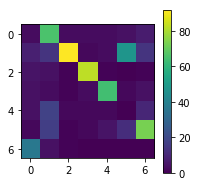

In [909]:
plot_gr(pcr.to_graph(7), s = 3)

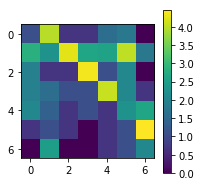

In [920]:
plot_gr(pcr.to_graph(7), s = 3, log = 1)

In [910]:
p_list

[[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0], [0, 1, 0, 5, 0, 6, 0]]

In [762]:
pcr.glue_f_to_b(2,3,0,2)

In [763]:
pcr.glue_b_to_f(1,4, 2,1)

In [688]:
if bj > 0 and self.bp.p[bi][bj - 1] == -1:
    copy_part = self.fp.p[fi][:fj][self.fp.p[fi][:fj] != -1][fj - bj:fj]
    self.fp.p[bi][bj - copy_part.shape[0]:bj] = copy_part

NameError: name 'bj' is not defined

In [641]:
pcr.print_glue_points()

1 2 ;  0 2 ;  0 4
2 1 ;  0 4 ;  0 2
5 6 ;  1 2 ;  1 4
6 5 ;  1 4 ;  1 2


In [612]:
pcr._amplify()

1 17 ;  0 2 ;  3 4
3 22 ;  0 6 ;  4 4
6 6 ;  1 2 ;  1 2
7 8 ;  1 4 ;  1 6
8 7 ;  1 6 ;  1 4
17 1 ;  3 4 ;  0 2
22 3 ;  4 4 ;  0 6
27 27 ;  5 4 ;  5 4


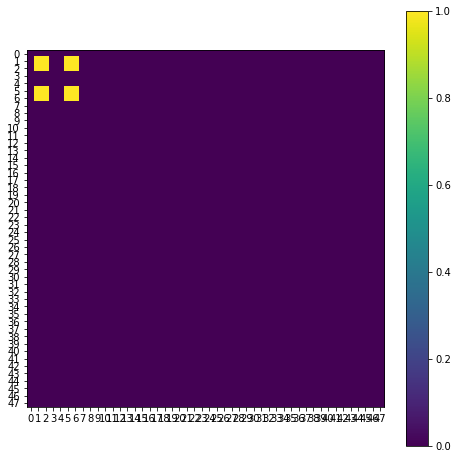

In [789]:
pcr._annealing()
plot_gr(pcr.comp_mat, s  = 8, all_ticks=1)

## TRY REAL

In [929]:
repeats_descr.mat = repeats_descr.mat**1.6

In [930]:
repeats_descr.mat

array([[1.        , 0.71379916, 0.48965248, 0.31938442],
       [0.71379916, 1.        , 0.71379916, 0.48965248],
       [0.48965248, 0.71379916, 1.        , 0.71379916],
       [0.31938442, 0.48965248, 0.71379916, 1.        ]])

In [931]:
p_list_0 = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(10)] + \
               [[4, 2, 5, 7, 11] for i in range(10)] + \
               [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
               [[1, 20, 22, 23, 21, 29]]

In [ ]:
p_list = []

for p in p_list_0:
    

In [912]:
p_list = [[0,0, 0,1, 0,2, 0,3, 0,4, 0], [0,1, 0,5, 0,6,0]]
primers_num = {0:1000, 1:1000}
p = Population(p_list, primers_num, max_len=16)

In [913]:
p.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [914]:
p.p[-2:]

array([[-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [915]:
pcr = PCR(p, repeats_descr)

In [916]:
pcr.fp.p

array([[-1, -1,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [917]:
pcr.bp.p[:10]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [918]:
for i in range(40):
    pcr.cycle()

1 300 ;  0 2 ;  37 8
4 4 ;  0 8 ;  0 8
5 84 ;  0 10 ;  10 8
11 572 ;  1 6 ;  71 8
20 20 ;  2 8 ;  2 8
28 228 ;  3 8 ;  28 8
52 100 ;  6 8 ;  12 8
60 516 ;  7 8 ;  64 8
84 5 ;  10 8 ;  0 10
100 52 ;  12 8 ;  6 8
124 612 ;  15 8 ;  76 8
132 492 ;  16 8 ;  61 8
140 436 ;  17 8 ;  54 8
156 756 ;  19 8 ;  94 8
164 708 ;  20 8 ;  88 8
180 652 ;  22 8 ;  81 8
204 484 ;  25 8 ;  60 8
228 28 ;  28 8 ;  3 8
236 540 ;  29 8 ;  67 8
260 524 ;  32 8 ;  65 8
268 548 ;  33 8 ;  68 8
276 604 ;  34 8 ;  75 8
292 764 ;  36 8 ;  95 8
300 1 ;  37 8 ;  0 2
308 340 ;  38 8 ;  42 8
324 444 ;  40 8 ;  55 8
332 748 ;  41 8 ;  93 8
340 308 ;  42 8 ;  38 8
348 716 ;  43 8 ;  89 8
412 556 ;  51 8 ;  69 8
436 140 ;  54 8 ;  17 8
444 324 ;  55 8 ;  40 8
468 780 ;  58 8 ;  97 8
484 204 ;  60 8 ;  25 8
492 132 ;  61 8 ;  16 8
508 812 ;  63 8 ;  101 8
516 60 ;  64 8 ;  7 8
524 260 ;  65 8 ;  32 8
532 620 ;  66 8 ;  77 8
540 236 ;  67 8 ;  29 8
548 268 ;  68 8 ;  33 8
556 412 ;  69 8 ;  51 8
572 11 ;  71 8 ;  1 6
580 6

380 60 ;  47 8 ;  7 8
388 148 ;  48 8 ;  18 8
412 780 ;  51 8 ;  97 8
444 700 ;  55 8 ;  87 8
452 468 ;  56 8 ;  58 8
468 452 ;  58 8 ;  56 8
492 188 ;  61 8 ;  23 8
508 564 ;  63 8 ;  70 8
540 732 ;  67 8 ;  91 8
548 660 ;  68 8 ;  82 8
564 508 ;  70 8 ;  63 8
572 812 ;  71 8 ;  101 8
580 316 ;  72 8 ;  39 8
596 708 ;  74 8 ;  88 8
628 68 ;  78 8 ;  8 8
660 548 ;  82 8 ;  68 8
700 444 ;  87 8 ;  55 8
708 596 ;  88 8 ;  74 8
732 540 ;  91 8 ;  67 8
764 772 ;  95 8 ;  96 8
772 764 ;  96 8 ;  95 8
780 412 ;  97 8 ;  51 8
788 308 ;  98 8 ;  38 8
796 244 ;  99 8 ;  30 8
804 228 ;  100 8 ;  28 8
812 572 ;  101 8 ;  71 8
2 692 ;  0 4 ;  86 8
3 92 ;  0 6 ;  11 8
4 52 ;  0 8 ;  6 8
6 244 ;  0 12 ;  30 8
10 420 ;  1 4 ;  52 8
11 564 ;  1 6 ;  70 8
13 796 ;  1 10 ;  99 8
20 148 ;  2 8 ;  18 8
36 684 ;  4 8 ;  85 8
52 4 ;  6 8 ;  0 8
76 460 ;  9 8 ;  57 8
84 276 ;  10 8 ;  34 8
92 3 ;  11 8 ;  0 6
100 292 ;  12 8 ;  36 8
116 636 ;  14 8 ;  79 8
140 612 ;  17 8 ;  76 8
148 20 ;  18 8 ;  2 8
172 53

396 796 ;  49 8 ;  99 8
412 700 ;  51 8 ;  87 8
420 10 ;  52 8 ;  1 4
428 716 ;  53 8 ;  89 8
436 28 ;  54 8 ;  3 8
444 764 ;  55 8 ;  95 8
452 516 ;  56 8 ;  64 8
476 780 ;  59 8 ;  97 8
516 452 ;  64 8 ;  56 8
524 308 ;  65 8 ;  38 8
532 572 ;  66 8 ;  71 8
548 196 ;  68 8 ;  24 8
572 532 ;  71 8 ;  66 8
588 1 ;  73 8 ;  0 2
596 756 ;  74 8 ;  94 8
628 36 ;  78 8 ;  4 8
660 812 ;  82 8 ;  101 8
668 140 ;  83 8 ;  17 8
676 52 ;  84 8 ;  6 8
692 364 ;  86 8 ;  45 8
700 412 ;  87 8 ;  51 8
708 260 ;  88 8 ;  32 8
716 428 ;  89 8 ;  53 8
732 156 ;  91 8 ;  19 8
756 596 ;  94 8 ;  74 8
764 444 ;  95 8 ;  55 8
780 476 ;  97 8 ;  59 8
796 396 ;  99 8 ;  49 8
812 660 ;  101 8 ;  82 8
1 420 ;  0 2 ;  52 8
3 644 ;  0 6 ;  80 8
6 6 ;  0 12 ;  0 12
13 572 ;  1 10 ;  71 8
28 148 ;  3 8 ;  18 8
36 540 ;  4 8 ;  67 8
44 340 ;  5 8 ;  42 8
52 748 ;  6 8 ;  93 8
92 92 ;  11 8 ;  11 8
100 548 ;  12 8 ;  68 8
116 444 ;  14 8 ;  55 8
148 28 ;  18 8 ;  3 8
180 412 ;  22 8 ;  51 8
188 516 ;  23 8 ;  64 8


380 636 ;  47 8 ;  79 8
388 628 ;  48 8 ;  78 8
396 436 ;  49 8 ;  54 8
436 396 ;  54 8 ;  49 8
452 748 ;  56 8 ;  93 8
468 356 ;  58 8 ;  44 8
484 100 ;  60 8 ;  12 8
516 68 ;  64 8 ;  8 8
540 260 ;  67 8 ;  32 8
572 140 ;  71 8 ;  17 8
596 684 ;  74 8 ;  85 8
604 6 ;  75 8 ;  0 12
620 11 ;  77 8 ;  1 6
628 388 ;  78 8 ;  48 8
636 380 ;  79 8 ;  47 8
644 732 ;  80 8 ;  91 8
660 316 ;  82 8 ;  39 8
684 596 ;  85 8 ;  74 8
692 364 ;  86 8 ;  45 8
732 644 ;  91 8 ;  80 8
748 452 ;  93 8 ;  56 8
780 268 ;  97 8 ;  33 8
796 180 ;  99 8 ;  22 8
1 508 ;  0 2 ;  63 8
2 196 ;  0 4 ;  24 8
3 380 ;  0 6 ;  47 8
4 284 ;  0 8 ;  35 8
5 292 ;  0 10 ;  36 8
10 388 ;  1 4 ;  48 8
12 660 ;  1 8 ;  82 8
28 28 ;  3 8 ;  3 8
44 164 ;  5 8 ;  20 8
60 428 ;  7 8 ;  53 8
76 372 ;  9 8 ;  46 8
100 604 ;  12 8 ;  75 8
116 300 ;  14 8 ;  37 8
140 156 ;  17 8 ;  19 8
156 140 ;  19 8 ;  17 8
164 44 ;  20 8 ;  5 8
180 468 ;  22 8 ;  58 8
196 2 ;  24 8 ;  0 4
228 228 ;  28 8 ;  28 8
236 676 ;  29 8 ;  84 8
244 244

11 740 ;  1 6 ;  92 8
13 300 ;  1 10 ;  37 8
28 700 ;  3 8 ;  87 8
36 660 ;  4 8 ;  82 8
76 372 ;  9 8 ;  46 8
100 516 ;  12 8 ;  64 8
108 332 ;  13 8 ;  41 8
116 140 ;  14 8 ;  17 8
140 116 ;  17 8 ;  14 8
148 756 ;  18 8 ;  94 8
164 684 ;  20 8 ;  85 8
172 500 ;  21 8 ;  62 8
212 284 ;  26 8 ;  35 8
220 772 ;  27 8 ;  96 8
236 540 ;  29 8 ;  67 8
252 564 ;  31 8 ;  70 8
260 340 ;  32 8 ;  42 8
284 212 ;  35 8 ;  26 8
300 13 ;  37 8 ;  1 10
332 108 ;  41 8 ;  13 8
340 260 ;  42 8 ;  32 8
348 348 ;  43 8 ;  43 8
372 76 ;  46 8 ;  9 8
404 620 ;  50 8 ;  77 8
428 460 ;  53 8 ;  57 8
444 652 ;  55 8 ;  81 8
460 428 ;  57 8 ;  53 8
476 676 ;  59 8 ;  84 8
500 172 ;  62 8 ;  21 8
516 100 ;  64 8 ;  12 8
540 236 ;  67 8 ;  29 8
564 252 ;  70 8 ;  31 8
604 604 ;  75 8 ;  75 8
620 404 ;  77 8 ;  50 8
644 732 ;  80 8 ;  91 8
652 444 ;  81 8 ;  55 8
660 36 ;  82 8 ;  4 8
676 476 ;  84 8 ;  59 8
684 164 ;  85 8 ;  20 8
700 28 ;  87 8 ;  3 8
716 812 ;  89 8 ;  101 8
732 644 ;  91 8 ;  80 8
740 11 

ValueError: could not broadcast input array from shape (5) into shape (0)

In [905]:
pcr.fp.p[:3]

array([[ 0,  3,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0,  6,  0, -1],
       [-1,  1,  0,  2,  0,  1,  0,  5,  0,  6,  0,  0,  0,  1,  0,  2],
       [-1, -1, -1, -1, -1, -1, -1,  3,  0,  2,  0,  3,  0,  4,  0, -1]])

In [906]:
pcr.bp.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0,  1,  0,  5],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0,  1,  0,  2,  0,  3],
       [-1, -1, -1, -1, -1, -1, -1,  1,  0,  4,  0, -1, -1, -1, -1, -1]])

In [907]:
pcr.bp.p[0][2:][pcr.bp.p[0][2:] != -1]#[: 16 - 0]

array([0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 1, 0, 5])

In [908]:
pcr.to_graph(7)

array([[ 3., 66.,  3.,  3.,  3.,  4.,  7.],
       [ 8., 14., 92.,  2.,  3., 48., 14.],
       [ 5.,  4.,  1., 83.,  1.,  0.,  1.],
       [ 4.,  3.,  1.,  3., 64.,  2.,  4.],
       [ 4., 18.,  2.,  2.,  2.,  0., 10.],
       [ 2., 17.,  1.,  2.,  5., 12., 73.],
       [37.,  4.,  1.,  0.,  0.,  0.,  0.]])

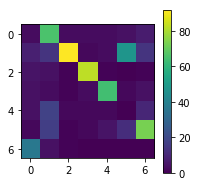

In [909]:
plot_gr(pcr.to_graph(7), s = 3)

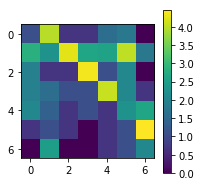

In [920]:
plot_gr(pcr.to_graph(7), s = 3, log = 1)

In [912]:
p_list = [[0,0, 0,1, 0,2, 0,3, 0,4, 0], [0,1, 0,5, 0,6,0]]
primers_num = {0:100}
p = Population(p_list, primers_num, max_len=16)

In [913]:
p.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [914]:
p.p[-2:]

array([[-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [915]:
pcr = PCR(p, repeats_descr)

In [916]:
pcr.fp.p

array([[-1, -1,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [917]:
pcr.bp.p[:10]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [918]:
for i in range(40):
    pcr.cycle()

1 300 ;  0 2 ;  37 8
4 4 ;  0 8 ;  0 8
5 84 ;  0 10 ;  10 8
11 572 ;  1 6 ;  71 8
20 20 ;  2 8 ;  2 8
28 228 ;  3 8 ;  28 8
52 100 ;  6 8 ;  12 8
60 516 ;  7 8 ;  64 8
84 5 ;  10 8 ;  0 10
100 52 ;  12 8 ;  6 8
124 612 ;  15 8 ;  76 8
132 492 ;  16 8 ;  61 8
140 436 ;  17 8 ;  54 8
156 756 ;  19 8 ;  94 8
164 708 ;  20 8 ;  88 8
180 652 ;  22 8 ;  81 8
204 484 ;  25 8 ;  60 8
228 28 ;  28 8 ;  3 8
236 540 ;  29 8 ;  67 8
260 524 ;  32 8 ;  65 8
268 548 ;  33 8 ;  68 8
276 604 ;  34 8 ;  75 8
292 764 ;  36 8 ;  95 8
300 1 ;  37 8 ;  0 2
308 340 ;  38 8 ;  42 8
324 444 ;  40 8 ;  55 8
332 748 ;  41 8 ;  93 8
340 308 ;  42 8 ;  38 8
348 716 ;  43 8 ;  89 8
412 556 ;  51 8 ;  69 8
436 140 ;  54 8 ;  17 8
444 324 ;  55 8 ;  40 8
468 780 ;  58 8 ;  97 8
484 204 ;  60 8 ;  25 8
492 132 ;  61 8 ;  16 8
508 812 ;  63 8 ;  101 8
516 60 ;  64 8 ;  7 8
524 260 ;  65 8 ;  32 8
532 620 ;  66 8 ;  77 8
540 236 ;  67 8 ;  29 8
548 268 ;  68 8 ;  33 8
556 412 ;  69 8 ;  51 8
572 11 ;  71 8 ;  1 6
580 6

380 60 ;  47 8 ;  7 8
388 148 ;  48 8 ;  18 8
412 780 ;  51 8 ;  97 8
444 700 ;  55 8 ;  87 8
452 468 ;  56 8 ;  58 8
468 452 ;  58 8 ;  56 8
492 188 ;  61 8 ;  23 8
508 564 ;  63 8 ;  70 8
540 732 ;  67 8 ;  91 8
548 660 ;  68 8 ;  82 8
564 508 ;  70 8 ;  63 8
572 812 ;  71 8 ;  101 8
580 316 ;  72 8 ;  39 8
596 708 ;  74 8 ;  88 8
628 68 ;  78 8 ;  8 8
660 548 ;  82 8 ;  68 8
700 444 ;  87 8 ;  55 8
708 596 ;  88 8 ;  74 8
732 540 ;  91 8 ;  67 8
764 772 ;  95 8 ;  96 8
772 764 ;  96 8 ;  95 8
780 412 ;  97 8 ;  51 8
788 308 ;  98 8 ;  38 8
796 244 ;  99 8 ;  30 8
804 228 ;  100 8 ;  28 8
812 572 ;  101 8 ;  71 8
2 692 ;  0 4 ;  86 8
3 92 ;  0 6 ;  11 8
4 52 ;  0 8 ;  6 8
6 244 ;  0 12 ;  30 8
10 420 ;  1 4 ;  52 8
11 564 ;  1 6 ;  70 8
13 796 ;  1 10 ;  99 8
20 148 ;  2 8 ;  18 8
36 684 ;  4 8 ;  85 8
52 4 ;  6 8 ;  0 8
76 460 ;  9 8 ;  57 8
84 276 ;  10 8 ;  34 8
92 3 ;  11 8 ;  0 6
100 292 ;  12 8 ;  36 8
116 636 ;  14 8 ;  79 8
140 612 ;  17 8 ;  76 8
148 20 ;  18 8 ;  2 8
172 53

396 796 ;  49 8 ;  99 8
412 700 ;  51 8 ;  87 8
420 10 ;  52 8 ;  1 4
428 716 ;  53 8 ;  89 8
436 28 ;  54 8 ;  3 8
444 764 ;  55 8 ;  95 8
452 516 ;  56 8 ;  64 8
476 780 ;  59 8 ;  97 8
516 452 ;  64 8 ;  56 8
524 308 ;  65 8 ;  38 8
532 572 ;  66 8 ;  71 8
548 196 ;  68 8 ;  24 8
572 532 ;  71 8 ;  66 8
588 1 ;  73 8 ;  0 2
596 756 ;  74 8 ;  94 8
628 36 ;  78 8 ;  4 8
660 812 ;  82 8 ;  101 8
668 140 ;  83 8 ;  17 8
676 52 ;  84 8 ;  6 8
692 364 ;  86 8 ;  45 8
700 412 ;  87 8 ;  51 8
708 260 ;  88 8 ;  32 8
716 428 ;  89 8 ;  53 8
732 156 ;  91 8 ;  19 8
756 596 ;  94 8 ;  74 8
764 444 ;  95 8 ;  55 8
780 476 ;  97 8 ;  59 8
796 396 ;  99 8 ;  49 8
812 660 ;  101 8 ;  82 8
1 420 ;  0 2 ;  52 8
3 644 ;  0 6 ;  80 8
6 6 ;  0 12 ;  0 12
13 572 ;  1 10 ;  71 8
28 148 ;  3 8 ;  18 8
36 540 ;  4 8 ;  67 8
44 340 ;  5 8 ;  42 8
52 748 ;  6 8 ;  93 8
92 92 ;  11 8 ;  11 8
100 548 ;  12 8 ;  68 8
116 444 ;  14 8 ;  55 8
148 28 ;  18 8 ;  3 8
180 412 ;  22 8 ;  51 8
188 516 ;  23 8 ;  64 8


380 636 ;  47 8 ;  79 8
388 628 ;  48 8 ;  78 8
396 436 ;  49 8 ;  54 8
436 396 ;  54 8 ;  49 8
452 748 ;  56 8 ;  93 8
468 356 ;  58 8 ;  44 8
484 100 ;  60 8 ;  12 8
516 68 ;  64 8 ;  8 8
540 260 ;  67 8 ;  32 8
572 140 ;  71 8 ;  17 8
596 684 ;  74 8 ;  85 8
604 6 ;  75 8 ;  0 12
620 11 ;  77 8 ;  1 6
628 388 ;  78 8 ;  48 8
636 380 ;  79 8 ;  47 8
644 732 ;  80 8 ;  91 8
660 316 ;  82 8 ;  39 8
684 596 ;  85 8 ;  74 8
692 364 ;  86 8 ;  45 8
732 644 ;  91 8 ;  80 8
748 452 ;  93 8 ;  56 8
780 268 ;  97 8 ;  33 8
796 180 ;  99 8 ;  22 8
1 508 ;  0 2 ;  63 8
2 196 ;  0 4 ;  24 8
3 380 ;  0 6 ;  47 8
4 284 ;  0 8 ;  35 8
5 292 ;  0 10 ;  36 8
10 388 ;  1 4 ;  48 8
12 660 ;  1 8 ;  82 8
28 28 ;  3 8 ;  3 8
44 164 ;  5 8 ;  20 8
60 428 ;  7 8 ;  53 8
76 372 ;  9 8 ;  46 8
100 604 ;  12 8 ;  75 8
116 300 ;  14 8 ;  37 8
140 156 ;  17 8 ;  19 8
156 140 ;  19 8 ;  17 8
164 44 ;  20 8 ;  5 8
180 468 ;  22 8 ;  58 8
196 2 ;  24 8 ;  0 4
228 228 ;  28 8 ;  28 8
236 676 ;  29 8 ;  84 8
244 244

11 740 ;  1 6 ;  92 8
13 300 ;  1 10 ;  37 8
28 700 ;  3 8 ;  87 8
36 660 ;  4 8 ;  82 8
76 372 ;  9 8 ;  46 8
100 516 ;  12 8 ;  64 8
108 332 ;  13 8 ;  41 8
116 140 ;  14 8 ;  17 8
140 116 ;  17 8 ;  14 8
148 756 ;  18 8 ;  94 8
164 684 ;  20 8 ;  85 8
172 500 ;  21 8 ;  62 8
212 284 ;  26 8 ;  35 8
220 772 ;  27 8 ;  96 8
236 540 ;  29 8 ;  67 8
252 564 ;  31 8 ;  70 8
260 340 ;  32 8 ;  42 8
284 212 ;  35 8 ;  26 8
300 13 ;  37 8 ;  1 10
332 108 ;  41 8 ;  13 8
340 260 ;  42 8 ;  32 8
348 348 ;  43 8 ;  43 8
372 76 ;  46 8 ;  9 8
404 620 ;  50 8 ;  77 8
428 460 ;  53 8 ;  57 8
444 652 ;  55 8 ;  81 8
460 428 ;  57 8 ;  53 8
476 676 ;  59 8 ;  84 8
500 172 ;  62 8 ;  21 8
516 100 ;  64 8 ;  12 8
540 236 ;  67 8 ;  29 8
564 252 ;  70 8 ;  31 8
604 604 ;  75 8 ;  75 8
620 404 ;  77 8 ;  50 8
644 732 ;  80 8 ;  91 8
652 444 ;  81 8 ;  55 8
660 36 ;  82 8 ;  4 8
676 476 ;  84 8 ;  59 8
684 164 ;  85 8 ;  20 8
700 28 ;  87 8 ;  3 8
716 812 ;  89 8 ;  101 8
732 644 ;  91 8 ;  80 8
740 11 

ValueError: could not broadcast input array from shape (5) into shape (0)

In [905]:
pcr.fp.p[:3]

array([[ 0,  3,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0,  6,  0, -1],
       [-1,  1,  0,  2,  0,  1,  0,  5,  0,  6,  0,  0,  0,  1,  0,  2],
       [-1, -1, -1, -1, -1, -1, -1,  3,  0,  2,  0,  3,  0,  4,  0, -1]])

In [906]:
pcr.bp.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0,  1,  0,  5],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0,  1,  0,  2,  0,  3],
       [-1, -1, -1, -1, -1, -1, -1,  1,  0,  4,  0, -1, -1, -1, -1, -1]])

In [907]:
pcr.bp.p[0][2:][pcr.bp.p[0][2:] != -1]#[: 16 - 0]

array([0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 1, 0, 5])

In [908]:
pcr.to_graph(7)

array([[ 3., 66.,  3.,  3.,  3.,  4.,  7.],
       [ 8., 14., 92.,  2.,  3., 48., 14.],
       [ 5.,  4.,  1., 83.,  1.,  0.,  1.],
       [ 4.,  3.,  1.,  3., 64.,  2.,  4.],
       [ 4., 18.,  2.,  2.,  2.,  0., 10.],
       [ 2., 17.,  1.,  2.,  5., 12., 73.],
       [37.,  4.,  1.,  0.,  0.,  0.,  0.]])

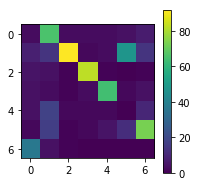

In [909]:
plot_gr(pcr.to_graph(7), s = 3)

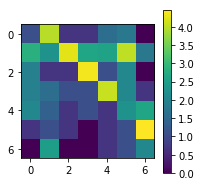

In [920]:
plot_gr(pcr.to_graph(7), s = 3, log = 1)

In [423]:
pcr._amplify()

0 (0, 1)
1 (0, 3)
2 (0, 5)
3 (1, 1)
4 (1, 3)
5 (1, 5)
5 (1, 5)
6 (2, 1)
8 (2, 5)
8 (2, 5)
8 (2, 5)
8 (2, 5)
12 (4, 1)
12 (4, 1)
12 (4, 1)
16 (5, 3)
16 (5, 3)
20 (6, 5)
20 (6, 5)


In [412]:
for a, b in zip(np.where(pcr.anneal == 1)[0], np.where(pcr.anneal == 1)[1]):
    print(a)

0
1
2
2
3
4
4
5
5
6
6
8
12
12
16
20
20
20


In [397]:
np.where(pcr.anneal == 1)[0]

array([ 0,  1,  2,  3,  4,  5,  5,  5,  6,  8,  8,  8, 12, 12, 12, 16, 20])

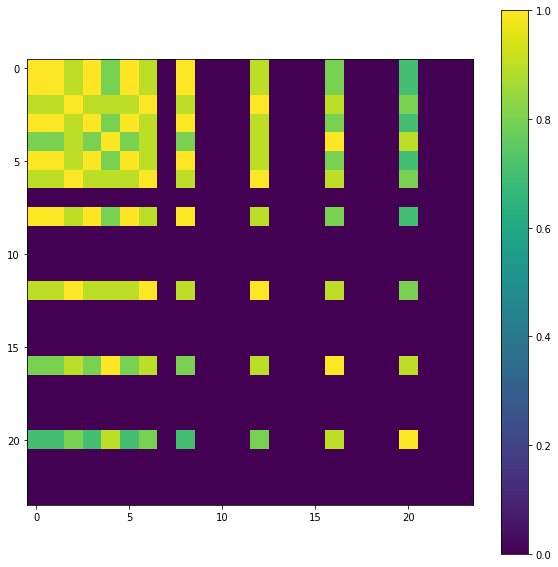

In [354]:
plot_gr(pcr.comp_mat)

In [101]:
p.bp

array([[ 0.,  0.,  0.,  0.,  1.,  1.,  2.,  0., -1.],
       [ 0.,  2.,  3.,  0.,  4.,  1., -1., -1., -1.],
       [ 1.,  0., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  2., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  3., -1., -1., -1., -1., -1., -1., -1.]])

In [106]:
p.fp[:,1:]

array([[ 0.,  0.,  0.,  1.,  1.,  2.,  0., -1.],
       [ 2.,  3.,  0.,  4.,  1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1.],
       [ 2., -1., -1., -1., -1., -1., -1., -1.],
       [ 3., -1., -1., -1., -1., -1., -1., -1.]])

In [92]:
complementaries = np.zeros((24,24))

In [104]:
sh = p.bp[:,1:].shape

In [107]:
p.bp[:,1::2]

array([[ 0.,  0.,  1.,  0.],
       [ 2.,  0.,  1., -1.],
       [ 0., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       [ 2., -1., -1., -1.],
       [ 3., -1., -1., -1.]])

In [ ]:
complementary_b_to_f = np.zeros

In [316]:
m = repeats_descr.mat

In [312]:
p.amplify(repeats_descr.mat, {})

[[0.  0.  0.  0. ]
 [1.  0.9 0.8 0.7]
 [1.  0.9 0.8 0.7]
 [0.9 1.  0.9 0.8]
 [1.  0.9 0.8 0.7]
 [0.8 0.9 1.  0.9]
 [1.  0.9 0.8 0.7]
 [0.9 1.  0.9 0.8]
 [0.9 1.  0.9 0.8]]


In [315]:
for x in p.p.flatten():
    print(x)

-1
-1
0
0
0
1
1
2
0
-1
2
3
0
4
1
-1
1
5
2
-1


In [317]:
m

array([[1. , 0.9, 0.8, 0.7],
       [0.9, 1. , 0.9, 0.8],
       [0.8, 0.9, 1. , 0.9],
       [0.7, 0.8, 0.9, 1. ]])

In [ ]:
np.random.choice(np.arange(12).reshape((3,4)), size = 4, p = 

In [267]:
def single_amplify(to_amplify, population=None, v = False):
    if population is None:
        population = [x for x in to_amplify]
    
    new = []
    for chain in to_amplify:
        start = np.random.randint(0, len(chain) - 1)
        stop = False
        end = np.random.randint(start + 1, len(chain))

        new_chain = []
        pointer = start

        while not stop:
            switch = np.random.rand() < SWITCH_PROB

            if v:
                print(chain, new_chain, switch)
            if switch:
                chain = population[np.random.randint(0, len(population))]
                pointer = np.random.randint(1, len(chain))

            if np.random.rand() < STOP_PROB:
                stop = True

            if len(new_chain) >= end - start:
                stop = True

            if pointer < len(chain):
                new_chain.append(chain[pointer])
            else:
                stop = True

            pointer += 1 

        if len(new_chain) > 2:
            new.append(new_chain)
    
    return [x[::-1] for x in new]

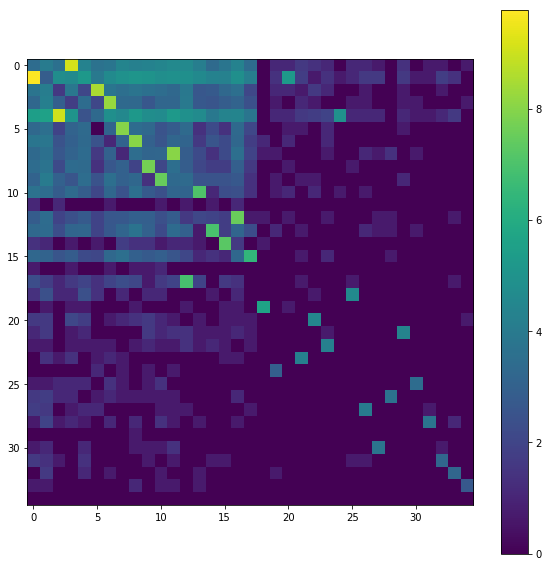

In [126]:
plot_gr(np.load("../../data/graphs/ES3_22.npy")[:35,:35], log = 1)

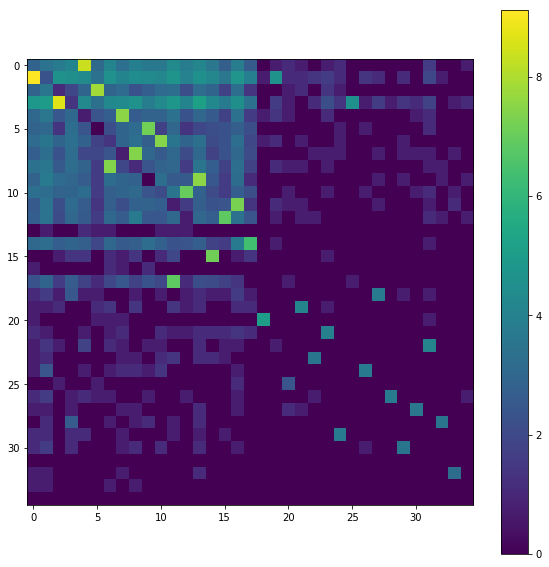

In [127]:
plot_gr(np.load("../../data/graphs/ES4_22.npy")[:35,:35], log = 1)